# Whatsapp Chat Analyzer

## Introduction

WhatsApp has become one of the most trendy social media platform. WhatsApp Chat Analyzer means is a platform that tracks our conversation and analyses group activities and how much time we are spending on WhatsApp.

## Data Extraction

I used different python libraries to extract useful information from raw whatsapp data data

### Import Required Libraries

In [42]:
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt 
from seaborn import * 
import seaborn as sns 
%matplotlib inline 
from datetime import * 
import datetime as dt 
from matplotlib.ticker import MaxNLocator 
import emoji
# from heatmap import heatmap 
from wordcloud import WordCloud , STOPWORDS ,ImageColorGenerator 
# from nltk import * 
from plotly import express as px
import datetime
from datetime import datetime
import textwrap


import os 
import re
import warnings 
warnings.filterwarnings('ignore')

#### Extract Date and Time

In [72]:
def extractDateAndTime(s):
    pattern = '^([0-9]+)(/)([0-9]+)(/)([0-9][0-9][0-9][0-9]), ([0-9]+):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

#### Extract Username and Author

In [73]:
def findAuthor(s): 
    patterns = ['([w]+):', # First Name 
                '([w]+[s]+[w]+):', # First Name + Last Name 
                '([w]+[s]+[w]+[s]+[w]+):', # First Name + Middle Name + Last Name 
                '([+]d{2} d{5} d{5}):', # Mobile Number (India no.) 
                '([+]d{2} d{3} d{3} d{4}):', # Mobile Number (US no.) 
                '([+]d{3} d{3} d{6}):', # Mobile Number (Kenya no.) 
                '([w]+)[u263a - U0001f999]+:', # Name and Emoji 
                ]
    
    pattern = '^ (([w]+):) | (([w]+[s]+[w]+):) | (([w]+[s]+[w]+[s]+[w]+):) | (([+]d{2} d{5} d{5}):) | (([+]d{2} d{3} d{3} d{4})) | (([+]d{3} d{3} d{6}):) | (([w]+)[u263a - U0001f999]+:)'
                
     
    # pattern = '^' + ' | '.join(patterns) 
    result = re.match(pattern, s) 
    if result: 
        return True 
    return False 

In [74]:
def getDataPoint(line): 
    splitLine = line.split(' - ') 
    dateTime = splitLine[0] 
    date, time = dateTime.split(',') 
    message = ' '.join(splitLine[1:]) 
    splitMessage = message.split(': ') 
    authorInfo = splitMessage[0] 
    message = ' '.join(splitMessage[1:])
    return date, time, authorInfo, message

s = '03/06/2022, 18:44 - Afi Naist: Elhaa paraaaahhhh'
getDataPoint(s)

('03/06/2022', ' 18:44', 'Afi Naist', 'Elhaa paraaaahhhh')

#### Creating Data Frame

In [75]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
### Uploading exported chat file
conversationPath = 'WhatsApp Chat with Vivo Lover.txt' # chat file
with open(conversationPath, encoding="utf-8") as fp:
    ### Skipping first line of the file because contains information related to something about end-to-end encryption
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if extractDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
### changing datatype of "Date" column.
df["Date"] = pd.to_datetime(df["Date"])

In [80]:
df["Message"]= df["Message"].str.pad(3, side ='both')
df["Author"]= df["Author"].str.pad(0, side ='left')
df.tail()

,Date,Time,Author,Message
5868,2022-10-24,15:35,Afi Naist,Ada yg mau sholatbrg diBio?
5869,2022-10-24,15:36,alqaaf (アルカフ) NAIST,masih lab meeting pak
5870,2022-10-24,15:36,Afi Naist,Eh ada to?
5871,2022-10-24,15:36,Afi Naist,😷
5872,2022-10-24,15:36,Rezi,Sama lagi lab meeting


In [82]:
df.to_excel('Data\extractedData.xlsx', index=False)

## Data Wrangling

The data to be cleansed is stored as extractedData.csv.

### Data Understanding

To understand this data, I seek to answer the following questions:
- How many active participants are in the group?
- How many texts and media have been sent to the group?
- What are the commonly used words in the group chat.
- What are the emotions attached to every user?
- What are the trends in chatting in the group?

#### Load Data

In [83]:
data = pd.read_excel('Data\extractedData.xlsx')
data.head()

,Date,Time,Author,Message
0,2022-03-06,18:42,"You created group ""Anti vivo""",
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5873 entries, 0 to 5872
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5873 non-null   datetime64[ns]
 1   Time     5873 non-null   object        
 2   Author   5873 non-null   object        
 3   Message  5873 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 183.7+ KB


In [85]:
data.describe()

,Date,Time,Author,Message
count,5873,5873,5873,5873
unique,113,981,9,4776
top,2022-09-27 00:00:00,18:10,Rezi,<Media omitted>
freq,403,27,2121,700
first,2022-01-08 00:00:00,NaN,NaN,NaN
last,2022-12-10 00:00:00,NaN,NaN,NaN


#### Cleansing Data

In [106]:
data_clean = data.copy()

#### Dropping Missing and Incorrect Values

In [107]:
data_clean = data_clean.loc[~((data_clean['Author'].isnull()==True) & (data_clean['Time'].isnull()==True)),:]
data_clean.head()

,Date,Time,Author,Message
0,2022-03-06,18:42,"You created group ""Anti vivo""",
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak


In [108]:
data_clean[data_clean['Message'] == '']

,Date,Time,Author,Message


In [109]:
data_clean.tail()

,Date,Time,Author,Message
5868,2022-10-24,15:35,Afi Naist,Ada yg mau sholatbrg diBio?
5869,2022-10-24,15:36,alqaaf (アルカフ) NAIST,masih lab meeting pak
5870,2022-10-24,15:36,Afi Naist,Eh ada to?
5871,2022-10-24,15:36,Afi Naist,😷
5872,2022-10-24,15:36,Rezi,Sama lagi lab meeting


In [110]:
print(data_clean.shape)
print(data.shape)

(5873, 4)
(5873, 4)


In [112]:
data_clean =data_clean[~data_clean['Author'].str.contains('left|joined|added|changed')]

# count = 0
# for s in data_clean.AuthorInfo:
#     if len(s.split(' ')) > 6:
#        data_clean = data_clean.drop(data_clean.index[count])
#     elif 'left' in s:
#         data_clean = data_clean.drop(data_clean.index[count])
#     elif 'joined' in s:
#         data_clean = data_clean.drop(data_clean.index[count])
#     elif 'changed' in s:
#         data_clean = data_clean.drop(data_clean.index[count])
#     count += 1

In [113]:
data.Message.iloc[10:20]

10                                       Rasis 🤣
11                                    mantap nih
12                                dosen vs dosen
13                             Elhaa paraaaahhhh
14                                        Iiihhh
15    saya mah mahasiswa nonton bapak2 dosen aja
16                                  Saya jg mhsw
17                                      Sama mas
18                                            🤣🤣
19                               <Media omitted>
Name: Message, dtype: object

#### Drop the incorrect values

In [116]:
data_clean = data_clean[~(data_clean['Message'] == None)]

In [117]:
print(data_clean)

           Date    Time                         Author  \
0    2022-03-06   18:42  You created group "Anti vivo"   
1    2022-03-06   18:43                           Rezi   
2    2022-03-06   18:43            alqaaf (アルカフ) NAIST   
3    2022-03-06   18:43                           Rezi   
4    2022-03-06   18:43            alqaaf (アルカフ) NAIST   
...         ...     ...                            ...   
5868 2022-10-24   15:35                      Afi Naist   
5869 2022-10-24   15:36            alqaaf (アルカフ) NAIST   
5870 2022-10-24   15:36                      Afi Naist   
5871 2022-10-24   15:36                      Afi Naist   
5872 2022-10-24   15:36                           Rezi   

                                               Message  
0                                                       
1                 Izin bikin grup biar mudah kordinasi  
2                               edannn nama grupnya 😂😂  
3     Ada lagi yg mau diinvite atau cukup segini dulu?  
4                 

## Most Used Words

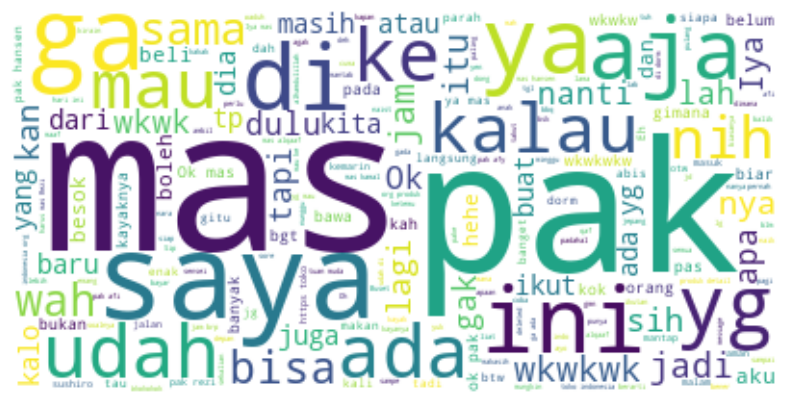

In [118]:
text = " ".join([review for review in data_clean.Message if len(review) > 2 and review != '<Media omitted>']) 
# text= [word for ]
wordcloud =WordCloud(stopwords=STOPWORDS, background_color="white").generate(text) 

### Display the generated image:
plt.figure( figsize=(10,5)) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

In [121]:
df = data_clean.copy()
df['message_count'] = [1] * df.shape[0]
df = df.groupby('Date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df

,Date,message_count
0,2022-01-08,104
1,2022-01-09,29
2,2022-01-10,100
3,2022-02-07,21
4,2022-02-08,6
...,...,...
108,2022-11-09,1
109,2022-11-10,56
110,2022-12-08,20
111,2022-12-09,21


### Most Active Days

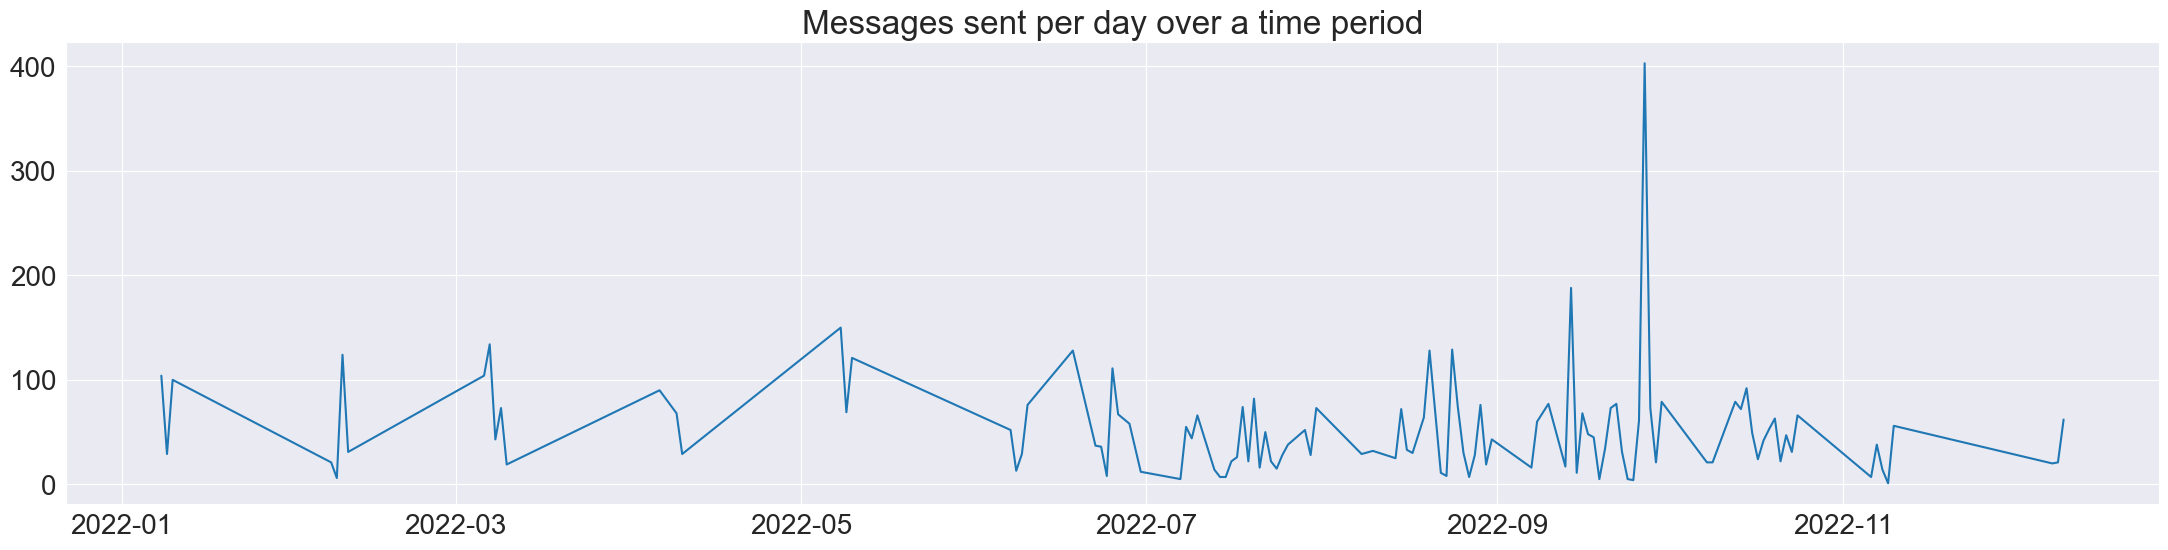

In [122]:
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df.Date, df.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
#plt.savefig('msg_plots.svg', format = 'svg')

In [123]:
top10days = df.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,Date,message_count
0,2022-09-27,403
1,2022-09-14,188
2,2022-05-08,150
3,2022-03-07,134
4,2022-08-24,129
5,2022-08-20,128
6,2022-06-18,128
7,2022-02-09,124
8,2022-05-10,121
9,2022-06-25,111


In [128]:
### Creates a list of unique Authors
l = data_clean.Author.unique()
for i in range(len(l)):
  ### Filtering out messages of particular user
  req_df = data_clean[data_clean["Author"] == l[i]]
  ### req_df will contain messages of only one particular user
  print(l[i],'  ->  ',req_df.shape[0])

You created group "Anti vivo"   ->   1
Rezi   ->   2121
alqaaf (アルカフ) NAIST   ->   1097
Hanssen Naist   ->   507
Afi Naist   ->   1300
Mas Kamal Naist   ->   844


## Feature Engineering
### Extract Phone Number

In [130]:
data_clean.columns

Index(['Date', 'Time', 'Author', 'Message'], dtype='object')

In [131]:
data_clean.head(10)

,Date,Time,Author,Message
0,2022-03-06,18:42,"You created group ""Anti vivo""",
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak
5,2022-03-06,18:43,Rezi,Gausah ditanya
6,2022-03-06,18:43,Rezi,Diinvite aja
7,2022-03-06,18:43,Hanssen Naist,<Media omitted>
8,2022-03-06,18:44,Rezi,<Media omitted>
9,2022-03-06,18:44,alqaaf (アルカフ) NAIST,saya gak ikutan pak wkwkwkw


In [132]:
new_data = data_clean.drop(labels=[0], axis = 0, inplace=False)
new_data.head(5)

,Date,Time,Author,Message
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak
5,2022-03-06,18:43,Rezi,Gausah ditanya


In [133]:
new_data['PhoneNumber'] = 0
new_data['Name'] = 0
count = 0
for x in new_data.Author:
    if re.findall(r'\d+', x) :
        new_data['PhoneNumber'].iloc[count] = x
        # print('{} - '.format(count) + x)
    else:
        new_data['Name'].iloc[count] = x
        # print('{} - Match not found'.format(count))
    count += 1

In [134]:
new_data.head()

,Date,Time,Author,Message,PhoneNumber,Name
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi,0,Rezi
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂,0,alqaaf (アルカフ) NAIST
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?,0,Rezi
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak,0,alqaaf (アルカフ) NAIST
5,2022-03-06,18:43,Rezi,Gausah ditanya,0,Rezi


### Media Extraction

In [135]:
# data_clean['Media'] = np.where(data_clean['Message'] == '<Media omitted>',1 ,0)

MEDIAPATTERN = r'<Media omitted>'
new_data['Media'] = new_data.Message.apply(lambda x : re.findall(MEDIAPATTERN, x)).str.len()

In [136]:
# count = 0
# for s in data_clean.Message:
#     if '<Media omitted>' in s:
#         data_clean['Media'].iloc[count] = 1
#     else:
#         data_clean['Media'].iloc[count] = 0
#     count += 1

In [138]:
new_data.head(10)

,Date,Time,Author,Message,PhoneNumber,Name,Media
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi,0,Rezi,0
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂,0,alqaaf (アルカフ) NAIST,0
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?,0,Rezi,0
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak,0,alqaaf (アルカフ) NAIST,0
5,2022-03-06,18:43,Rezi,Gausah ditanya,0,Rezi,0
6,2022-03-06,18:43,Rezi,Diinvite aja,0,Rezi,0
7,2022-03-06,18:43,Hanssen Naist,<Media omitted>,0,Hanssen Naist,1
8,2022-03-06,18:44,Rezi,<Media omitted>,0,Rezi,1
9,2022-03-06,18:44,alqaaf (アルカフ) NAIST,saya gak ikutan pak wkwkwkw,0,alqaaf (アルカフ) NAIST,0
10,2022-03-06,18:44,Hanssen Naist,Rasis 🤣,0,Hanssen Naist,0


### Extract Links

In [139]:
new_data['Message'].iloc[12:20]

13                             Elhaa paraaaahhhh
14                                        Iiihhh
15    saya mah mahasiswa nonton bapak2 dosen aja
16                                  Saya jg mhsw
17                                      Sama mas
18                                            🤣🤣
19                               <Media omitted>
20                               <Media omitted>
Name: Message, dtype: object

In [140]:
new_data['Link'] = np.where(new_data['Message'].str.contains('http:|https:|.com |.org |.us |.id |.jp |.be |.co |.dev |.gov'),1 ,0 )
# URLPATTERN = r'(https?://S+)'
# data_clean['Link'] = data_clean.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len() 

In [141]:
new_data.head(10)

,Date,Time,Author,Message,PhoneNumber,Name,Media,Link
1,2022-03-06,18:43,Rezi,Izin bikin grup biar mudah kordinasi,0,Rezi,0,0
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,edannn nama grupnya 😂😂,0,alqaaf (アルカフ) NAIST,0,0
3,2022-03-06,18:43,Rezi,Ada lagi yg mau diinvite atau cukup segini dulu?,0,Rezi,0,0
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,coba tanyain mas kamal pak,0,alqaaf (アルカフ) NAIST,0,0
5,2022-03-06,18:43,Rezi,Gausah ditanya,0,Rezi,0,0
6,2022-03-06,18:43,Rezi,Diinvite aja,0,Rezi,0,0
7,2022-03-06,18:43,Hanssen Naist,<Media omitted>,0,Hanssen Naist,1,0
8,2022-03-06,18:44,Rezi,<Media omitted>,0,Rezi,1,0
9,2022-03-06,18:44,alqaaf (アルカフ) NAIST,saya gak ikutan pak wkwkwkw,0,alqaaf (アルカフ) NAIST,0,0
10,2022-03-06,18:44,Hanssen Naist,Rasis 🤣,0,Hanssen Naist,0,0


In [142]:
new_data['Message'] = new_data['Message'].apply(lambda s: s.replace('\n', '  '))

### Reorder Columns

In [143]:
new_data = new_data[['Date', 'Time', 'Author', 'PhoneNumber', 'Name', 'Media', 'Link', 'Message']]
new_data.head()

,Date,Time,Author,PhoneNumber,Name,Media,Link,Message
1,2022-03-06,18:43,Rezi,0,Rezi,0,0,Izin bikin grup biar mudah kordinasi
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,0,alqaaf (アルカフ) NAIST,0,0,edannn nama grupnya 😂😂
3,2022-03-06,18:43,Rezi,0,Rezi,0,0,Ada lagi yg mau diinvite atau cukup segini dulu?
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,0,alqaaf (アルカフ) NAIST,0,0,coba tanyain mas kamal pak
5,2022-03-06,18:43,Rezi,0,Rezi,0,0,Gausah ditanya


In [144]:
new_data.to_excel('CleanedData.xlsx', index=False)

### Generating Date Time Features

In [145]:
weekDay = { 0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 :'Saturday', 6 : 'Sunday' } 

new_data['Days'] = new_data['Date'].dt.day_of_week.map(weekDay).astype('category')

In [146]:
new_data.head()

,Date,Time,Author,PhoneNumber,Name,Media,Link,Message,Days
1,2022-03-06,18:43,Rezi,0,Rezi,0,0,Izin bikin grup biar mudah kordinasi,Sunday
2,2022-03-06,18:43,alqaaf (アルカフ) NAIST,0,alqaaf (アルカフ) NAIST,0,0,edannn nama grupnya 😂😂,Sunday
3,2022-03-06,18:43,Rezi,0,Rezi,0,0,Ada lagi yg mau diinvite atau cukup segini dulu?,Sunday
4,2022-03-06,18:43,alqaaf (アルカフ) NAIST,0,alqaaf (アルカフ) NAIST,0,0,coba tanyain mas kamal pak,Sunday
5,2022-03-06,18:43,Rezi,0,Rezi,0,0,Gausah ditanya,Sunday


### Letters per-Message

In [147]:
new_data['LetterCount'] = new_data['Message'].apply(lambda x : len(x))

In [148]:
new_data.tail()

,Date,Time,Author,PhoneNumber,Name,Media,Link,Message,Days,LetterCount
5868,2022-10-24,15:35,Afi Naist,0,Afi Naist,0,0,Ada yg mau sholatbrg diBio?,Monday,27
5869,2022-10-24,15:36,alqaaf (アルカフ) NAIST,0,alqaaf (アルカフ) NAIST,0,0,masih lab meeting pak,Monday,21
5870,2022-10-24,15:36,Afi Naist,0,Afi Naist,0,0,Eh ada to?,Monday,10
5871,2022-10-24,15:36,Afi Naist,0,Afi Naist,0,0,😷,Monday,3
5872,2022-10-24,15:36,Rezi,0,Rezi,0,0,Sama lagi lab meeting,Monday,21


### Word Count per-Message

In [149]:
new_data['WordCount'] = new_data['Message'].apply(lambda x : len(x.split(' ')))

In [150]:
new_data.sample(5)

,Date,Time,Author,PhoneNumber,Name,Media,Link,Message,Days,LetterCount,WordCount
768,2022-03-07,16:37,Mas Kamal Naist,0,Mas Kamal Naist,0,0,itu udah bertiga?,Monday,17,3
4203,2022-09-27,14:30,Mas Kamal Naist,0,Mas Kamal Naist,0,0,lah pemalu karena bahasa inggris atau gmn pak,Tuesday,45,8
4840,2022-05-10,16:50,Rezi,0,Rezi,0,0,Mekiroy,Tuesday,7,1
937,2022-07-13,20:33,Hanssen Naist,0,Hanssen Naist,1,0,<Media omitted>,Wednesday,15,2
2803,2022-08-31,09:14,Rezi,0,Rezi,0,0,Waduh saya kwtinggalan wkwkwk,Wednesday,29,4


## Insight
### General Statistics

In [152]:
total_messages = new_data.shape[0] 
media_messages = new_data[new_data['Message'] == '<Media omitted>'].shape[0] 
# media_messages = np.sum(data_clean.Media) 
links =np.sum(new_data.Link) 
print('___________________Group Chatting Statistics___________________________________ \n') 
print('Total Number of Messages as of the data been extracted: {}'.format(total_messages)) 
print('Total Number of Media Messages as of the data been extracted: {}'.format(media_messages)) 
print('Total Number of Links as of the data been extracted: {}'.format(links))

___________________Group Chatting Statistics___________________________________ 

Total Number of Messages as of the data been extracted: 5869
Total Number of Media Messages as of the data been extracted: 700
Total Number of Links as of the data been extracted: 182


### User Statistics

In [153]:
users = new_data.Author.unique()

### Filtering out messages of particular user 

for user in users: 
    specific_user = new_data[new_data["Author"] == user]
    print(f'__________________ {user}\'s statistics _______________________') 
    print('Total Messages Sent : ', specific_user.shape[0]) 
    
    ### Average words per message 
    average_words_per_message = (np.sum(specific_user['WordCount']))/specific_user.shape[0]
    w_p_m = ("%.3f" % round(average_words_per_message, 2)) 
    print('Average Words per Message : ', w_p_m) 
    
    ### media conists of media messages 
    media = sum(specific_user["Media"]) 
    print('Total Media Messages Sent : ', media) 
    
    ### links consist of total links 
    links = sum(specific_user["Link"]) 
    print('Total Links Sent : \n', links) 
    # print(f'---------------------------------------------------------- \n')

__________________ Rezi's statistics _______________________
Total Messages Sent :  2121
Average Words per Message :  4.730
Total Media Messages Sent :  305
Total Links Sent : 
 81
__________________ alqaaf (アルカフ) NAIST's statistics _______________________
Total Messages Sent :  1097
Average Words per Message :  4.410
Total Media Messages Sent :  135
Total Links Sent : 
 31
__________________ Hanssen Naist's statistics _______________________
Total Messages Sent :  507
Average Words per Message :  4.240
Total Media Messages Sent :  148
Total Links Sent : 
 12
__________________ Afi Naist's statistics _______________________
Total Messages Sent :  1300
Average Words per Message :  4.590
Total Media Messages Sent :  84
Total Links Sent : 
 29
__________________ Mas Kamal Naist's statistics _______________________
Total Messages Sent :  844
Average Words per Message :  5.080
Total Media Messages Sent :  28
Total Links Sent : 
 29
